In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time

from torchvision import datasets, transforms
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

In [2]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

In [3]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
## Simple NN. You can change this if you want.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

In [6]:
# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())
model = model.to(device)
model.train()

Sequential(
  (0): Normalize()
  (1): Net(
    (fc): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
  )
)

### Implement the Attacks

In [7]:
# The last argument 'targeted' can be used to toggle between a targeted and untargeted attack.
def fgsm(model, x, target, eps, targeted=True):
    x_copy = x.clone().detach() 
    x_copy.requires_grad_()
    
    L = nn.CrossEntropyLoss()
    loss = L(model(x_copy), torch.tensor([target], dtype=torch.long))
    model.zero_grad()
    loss.backward()

    x_grad = x_copy.grad
    if targeted == True:
        x_prime = x_copy - eps * x_grad.detach().sign()
    else:
        x_prime = x_copy + eps * x_grad.detach().sign()
        
    x_clipped=torch.max(torch.min(x_prime, x + eps), x - eps)                # Clamp to between x-eps and x+eps
    x_adv=torch.max(torch.min(x_clipped, torch.tensor(1)), torch.tensor(0))  # Clamp back to image domain         
    return x_adv
    

In [8]:
original = torch.unsqueeze(test_dataset[0][0], dim=0)

In [9]:
def pgd_untargeted(model, x, labels, k, eps, eps_step):
    # Start from a random perturbation in the eps ball around a sample
    x_ptb = x + eps*torch.rand(x.size())
    x_clipped=torch.max(torch.min(x_ptb, x+eps), x-eps)
    x_iter=torch.max(torch.min(x_clipped, torch.tensor(1)), torch.tensor(0))
    
    #Project and Do FGSM
    for i in range(k):
        x_prime = fgsm(model, x_iter, labels, eps_step, targeted=False)
        x_projected = torch.max(torch.min(x_prime, x + eps), x - eps)        
        x_doubleprime = torch.max(torch.min(x_projected, torch.tensor(1)), torch.tensor(0))  # Clamp back to image domain
        x_iter = x_doubleprime
    return x_doubleprime
    

### Problem 2a. 

In [10]:
# Implement untargeted FGSM attack on Model.
# Step 1. Train the model on the unperturbed training set
# Step 2. Test the model on unperturbed testing set 
# Step 3. Test the model on FGSM attacked testing set

In [11]:
# Step 1. Train the model on the unperturbed training set
learning_rate = 0.0001
opt = optim.Adam(params=model.parameters(), lr=learning_rate)
ce_loss = torch.nn.CrossEntropyLoss()
for epoch in range(1, 5):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)             
        model.train()
        opt.zero_grad()
        out = model(x_batch)
        batch_loss = ce_loss(out, y_batch)
        batch_loss.backward()
        opt.step()

In [12]:
# Step 2. Test the model on unperturbed testing set 
model.eval()
tot_test, tot_acc = 0.0, 0.0
for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    out = model(x_batch)
    pred = torch.max(out, dim=1)[1]
    acc = pred.eq(y_batch).sum().item()
    tot_acc += acc
    tot_test += x_batch.size()[0]
    
print(f"Accuracy: {tot_acc/tot_test}")

Accuracy: 0.9537


In [21]:
# Function for generating adv_x_batch
def gen_adv_x_batch(x_batch, y_batch, type):
    list_adv_x_batch=[]
    for i in range(len(x_batch)):
        if type == 'pgd':
            adv = pgd_untargeted(model, x_batch[[i],:,:,:], labels=y_batch[i], k=5, eps=0.1,
                  eps_step=0.05)
        if type == 'fgsm':
            adv = fgsm(model, x_batch[[i],:,:,:], target=y_batch[i], eps=0.1, targeted=False)     
        list_adv_x_batch.append(adv)
    adv_x_batch=torch.cat(list_adv_x_batch, 0)
    return adv_x_batch

In [22]:
# Step 3. Test the model on FGSM attacked testing set
model.eval()
tot_test, tot_acc = 0.0, 0.0
for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    adv_x_batch = gen_adv_x_batch(x_batch, y_batch, 'fgsm')
    adv_x_batch = adv_x_batch.to(device)
    
    out = model(adv_x_batch)
    pred = torch.max(out, dim=1)[1]
    acc = pred.eq(y_batch).sum().item()
    tot_acc += acc
    tot_test += adv_x_batch.size()[0]
    
print(f"Accuracy: {tot_acc/tot_test}")

Accuracy: 0.2526


Text(0.5, 1.0, 'perturbed')

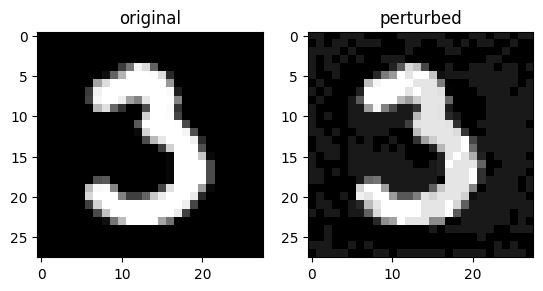

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x_batch[12,0,:,:].detach().numpy(), cmap='gray')
ax2.imshow(adv_x_batch[12,0,:,:].detach().numpy(), cmap='gray')
ax1.set_title('original')
ax2.set_title('perturbed')

### Problem 2b. 

In [18]:
# Implement untargeted PGD attack on Model.
# Step 1. Train the model on the unperturbed training set (already done in 2a)
# Step 2. Test the model on unperturbed testing set (already done in 2a)
# Step 3. Test the model on PGD attacked testing set

In [19]:
# Step 3. Test the model on PGD attacked testing set
model.eval()
tot_test, tot_acc = 0.0, 0.0
for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    adv_x_batch = gen_adv_x_batch(x_batch, y_batch, 'pgd')
    adv_x_batch = adv_x_batch.to(device)
    
    out = model(adv_x_batch)
    pred = torch.max(out, dim=1)[1]
    acc = pred.eq(y_batch).sum().item()
    tot_acc += acc
    tot_test += adv_x_batch.size()[0]
    
print(f"Accuracy: {tot_acc/tot_test}")

Accuracy: 0.187


Text(0.5, 1.0, 'perturbed')

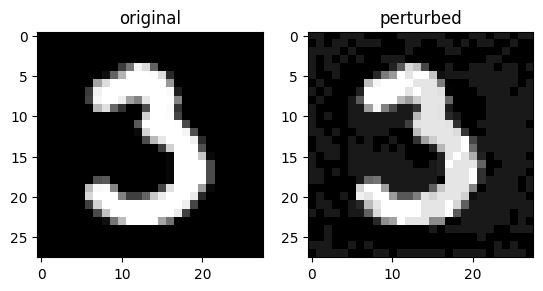

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x_batch[12,0,:,:].detach().numpy(), cmap='gray')
ax2.imshow(adv_x_batch[12,0,:,:].detach().numpy(), cmap='gray')
ax1.set_title('original')
ax2.set_title('perturbed')

### Implement Adversarial Training

In [31]:
def train_model(model, num_epochs, enable_defense=True):
    learning_rate = 0.0001
    opt = optim.Adam(params=model.parameters(), lr=learning_rate)
    ce_loss = torch.nn.CrossEntropyLoss()
    tot_steps = 0

    for epoch in range(1,num_epochs+1):
        t1 = time.time()
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            if enable_defense:
                model.eval()   # Switch to eval mode while generating attack
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                adv_x_batch = gen_adv_x_batch(x_batch, y_batch, 'pgd')
                adv_x_batch = adv_x_batch.to(device)

                model.train()
                out = model(adv_x_batch)
                batch_loss = ce_loss(out, y_batch)
                tot_steps += 1
                opt.zero_grad()
                batch_loss.backward()
                opt.step()

        tot_test, tot_acc = 0.0, 0.0
        for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            adv_x_batch = gen_adv_x_batch(x_batch, y_batch, 'pgd')
            adv_x_batch = adv_x_batch.to(device)
            out = model(adv_x_batch)
            pred = torch.max(out, dim=1)[1]
            acc = pred.eq(y_batch).sum().item()
            tot_acc += acc
            tot_test += x_batch.size()[0]
        t2 = time.time()

        print('Epoch %d: Accuracy %.5lf [%.2lf seconds]' % (epoch, tot_acc/tot_test, t2-t1))

In [32]:
train_model(model, 5, enable_defense=True)

Epoch 1: Accuracy 0.76300 [345.32 seconds]
Epoch 2: Accuracy 0.79820 [342.94 seconds]
Epoch 3: Accuracy 0.81480 [341.11 seconds]
Epoch 4: Accuracy 0.83060 [340.38 seconds]
Epoch 5: Accuracy 0.83700 [340.76 seconds]


### Adversarially Trained Model Performance PGD vs Original

In [39]:
# Model performance on PGD Adv Examples 
model.eval()
tot_test, tot_acc = 0.0, 0.0
for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    adv_x_batch = gen_adv_x_batch(x_batch, y_batch, 'pgd')
    adv_x_batch = adv_x_batch.to(device)
    
    out = model(adv_x_batch)
    pred = torch.max(out, dim=1)[1]
    acc = pred.eq(y_batch).sum().item()
    tot_acc += acc
    tot_test += adv_x_batch.size()[0]
    
print(f"Adv Accuracy: {tot_acc/tot_test}")

Adv Accuracy: 0.8371


In [37]:
# Model performance on Original Examples
model.eval()
tot_test, tot_acc = 0.0, 0.0
for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    out = model(x_batch)
    pred = torch.max(out, dim=1)[1]
    acc = pred.eq(y_batch).sum().item()
    tot_acc += acc
    tot_test += x_batch.size()[0]
    
print(f"Accuracy: {tot_acc/tot_test}")

Accuracy: 0.9669


### Extra Credit: PGD Adversarial Trained Model with FGSM Attacks

In [38]:
# PGD Trained Model performance on FGSM Adv Examples 
model.eval()
tot_test, tot_acc = 0.0, 0.0
for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    adv_x_batch = gen_adv_x_batch(x_batch, y_batch, 'fgsm')
    adv_x_batch = adv_x_batch.to(device)
    
    out = model(adv_x_batch)
    pred = torch.max(out, dim=1)[1]
    acc = pred.eq(y_batch).sum().item()
    tot_acc += acc
    tot_test += adv_x_batch.size()[0]
    
print(f"Adv Accuracy: {tot_acc/tot_test}")

Adv Accuracy: 0.8501
